<a href="https://colab.research.google.com/github/hysKim1/AIML-Study/blob/master/TensorFlow/Course_3_Week_2_Subwords_and_Sequences.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
# NOTE: PLEASE MAKE SURE YOU ARE RUNNING THIS IN A PYTHON3 ENVIRONMENT

import tensorflow as tf
print(tf.__version__)


2.3.0


> 기계에게 아무리 많은 단어를 학습시켜도, 세상의 모든 단어를 알려줄 수는 없는 노릇입니다. 만약, 기계가 모르는 단어가 등장하면 그 단어를 단어 집합에 없는 단어란 의미에서 OOV(Out-Of-Vocabulary) 또는 UNK(Unknown Token)라고 표현합니다. 

> 서브워드 분리(Subword segmenation) 작업은 하나의 단어는 더 작은 단위의 의미있는 여러 서브워드들(Ex) birthplace = birth + place)의 조합으로 구성된 경우가 많기 때문에, 하나의 단어를 여러 서브워드로 분리해서 단어를 인코딩 및 임베딩하겠다는 의도를 가진 전처리 작업입니다. 이를 통해 OOV나 희귀 단어, 신조어와 같은 문제를 완화시킬 수 있습니다. 실제로 언어의 특성에 따라 영어권 언어나 한국어는 서브워드 분리를 시도했을 때 어느정도 의미있는 단위로 나누는 것이 가능합니다.

https://wikidocs.net/22592


## [TensorFlow Datasets](https://github.com/tensorflow/datasets/tree/master/docs/catalog)

- [github](https://github.com/tensorflow/datasets/tree/master/docs/catalog)
- [imdb_reviews](https://github.com/tensorflow/datasets/blob/master/docs/catalog/imdb_reviews.md)


이전에는 직접 불용어 입력하여 처리하였지만 이번에는 tfds에서 제공하는 subwords8k 이용




In [3]:
# If the import fails, run this
# !pip install -q tensorflow-datasets

import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews/subwords8k", with_info=True, as_supervised=True)


In [4]:
train_data, test_data = imdb['train'], imdb['test']

In [5]:
tokenizer = info.features['text'].encoder

Subwords text encoder

In [6]:
print(tokenizer.subwords)  #pre-trained sub-words tokenizer 

['the_', ', ', '. ', 'a_', 'and_', 'of_', 'to_', 's_', 'is_', 'br', 'in_', 'I_', 'that_', 'this_', 'it_', ' /><', ' />', 'was_', 'The_', 'as_', 't_', 'with_', 'for_', '.<', 'on_', 'but_', 'movie_', ' (', 'are_', 'his_', 'have_', 'film_', 'not_', 'ing_', 'be_', 'ed_', 'you_', ' "', 'it', 'd_', 'an_', 'he_', 'by_', 'at_', 'one_', 'who_', 'y_', 'from_', 'e_', 'or_', 'all_', 'like_', 'they_', '" ', 'so_', 'just_', 'has_', ') ', 'her_', 'about_', 'out_', 'This_', 'some_', 'ly_', 'movie', 'film', 'very_', 'more_', 'It_', 'would_', 'what_', 'when_', 'which_', 'good_', 'if_', 'up_', 'only_', 'even_', 'their_', 'had_', 'really_', 'my_', 'can_', 'no_', 'were_', 'see_', 'she_', '? ', 'than_', '! ', 'there_', 'get_', 'been_', 'into_', ' - ', 'will_', 'much_', 'story_', 'because_', 'ing', 'time_', 'n_', 'we_', 'ed', 'me_', ': ', 'most_', 'other_', 'don', 'do_', 'm_', 'es_', 'how_', 'also_', 'make_', 'its_', 'could_', 'first_', 'any_', "' ", 'people_', 'great_', 've_', 'ly', 'er_', 'made_', 'r_', 'B

In [7]:

sample_string = 'TensorFlow, from basics to mastery'
#encoding
tokenized_string = tokenizer.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))
#decoding
original_string = tokenizer.decode(tokenized_string)
print ('The original string: {}'.format(original_string))


Tokenized string is [6307, 2327, 4043, 2120, 2, 48, 4249, 4429, 7, 2652, 8050]
The original string: TensorFlow, from basics to mastery


In [8]:
#Token mapping :case-sensitive, puntuation maintained
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
2 ----> , 
48 ----> from 
4249 ----> basi
4429 ----> cs 
7 ----> to 
2652 ----> master
8050 ----> y


In [9]:
BUFFER_SIZE = 10000
BATCH_SIZE = 1

train_dataset = train_data.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(train_dataset))
test_dataset = test_data.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(test_data))

In [10]:
embedding_dim = 64
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          523840    
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 524,237
Trainable params: 524,237
Non-trainable params: 0
_________________________________________________________________


In [11]:
num_epochs = 10

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

history = model.fit(train_dataset,epochs=num_epochs, validation_data=test_dataset)

Epoch 1/10
25000/25000 [==============================] - 211s 8ms/step - loss: 0.3401 - accuracy: 0.8502 - val_loss: 0.2992 - val_accuracy: 0.8752
Epoch 2/10
25000/25000 [==============================] - 204s 8ms/step - loss: 0.2177 - accuracy: 0.9174 - val_loss: 0.3277 - val_accuracy: 0.8658
Epoch 3/10
25000/25000 [==============================] - 203s 8ms/step - loss: 0.1798 - accuracy: 0.9335 - val_loss: 0.3341 - val_accuracy: 0.8692
Epoch 4/10
25000/25000 [==============================] - 214s 9ms/step - loss: 0.1544 - accuracy: 0.9440 - val_loss: 0.3866 - val_accuracy: 0.8636
Epoch 5/10
25000/25000 [==============================] - 213s 9ms/step - loss: 0.1348 - accuracy: 0.9506 - val_loss: 0.4075 - val_accuracy: 0.8601
Epoch 6/10
25000/25000 [==============================] - 215s 9ms/step - loss: 0.1173 - accuracy: 0.9575 - val_loss: 0.4770 - val_accuracy: 0.8568
Epoch 7/10
25000/25000 [==============================] - 215s 9ms/step - loss: 0.1037 - accuracy: 0.9610 - val_

subwords에서는 Sequence 가 중요한데 이 관계가 무시되어 있음 
- RNN 사용하는 이유

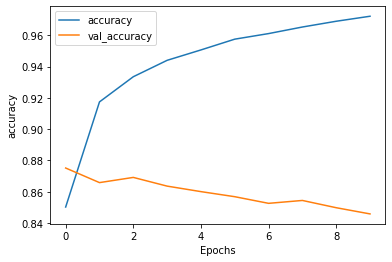

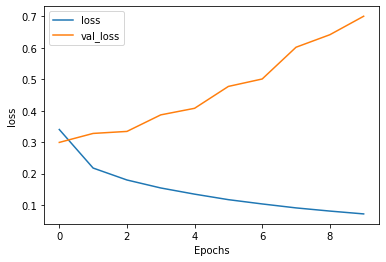

In [12]:

import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, tokenizer.vocab_size):
  word = tokenizer.decode([word_num])
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()


try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')